# Part 7 — Transfer Learning with PyTorch

**Goal:** build a strong image classifier for three food classes using **transfer learning**.  
We’ll start with **feature extraction** (freeze the backbone) and then **fine‑tune** the top layers for extra gains.

> You can run this notebook on CPU, but a GPU is highly recommended (Colab: *Runtime → Change runtime type → GPU*).



## Why transfer learning?

Training deep models from scratch needs lots of data and compute. Transfer learning lets us:
- **Reuse** a backbone already trained on a large dataset (e.g., ImageNet).
- **Adapt** the last layers to our small, specific dataset.
- **Train faster** and often reach **better accuracy** with less data.

In this project you will:
1. Download a small **pizza/steak/sushi** dataset.
2. Prepare **DataLoaders** with the exact transforms the pretrained model expects.
3. Build a model with a pretrained **backbone** and a custom **classifier head**.
4. Train in two stages: **feature extraction** → **fine‑tuning**.
5. Evaluate with a **confusion matrix**, view **misclassifications**, and test on a **custom image**.
6. Try a few **exercises** to go deeper.


## 0. Environment & setup

In [ ]:
#@title Install/Check versions
import sys, subprocess, importlib

def pip_install(pkg):
    print(f"Installing {pkg} ...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# Try import, otherwise install
try:
    import torch, torchvision
    from packaging import version
    # Basic sanity checks (these are flexible; you can still run with older versions)
    print("torch:", torch.__version__)
    print("torchvision:", torchvision.__version__)
except Exception as e:
    print("PyTorch not found, installing stable CPU/GPU build...")
    pip_install("torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121")
    import torch, torchvision

device = "cuda" if (hasattr(torch, "cuda") and torch.cuda.is_available()) else "cpu"
device


torch: 2.8.0+cu126
torchvision: 0.23.0+cu126


'cuda'

In [ ]:
#@title Imports & utility helpers
import os, random, math, time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torchvision.transforms.functional import to_pil_image

from tqdm.auto import tqdm

# Reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("Device:", device)


Device: cuda


## 1. Data: download and inspect

We’ll use a compact dataset with three classes: **pizza**, **steak**, and **sushi**.  
The folder layout is already in image‑classification format:

```
data/pizza_steak_sushi/
├── train/
│   ├── pizza/ ... .jpg
│   ├── steak/ ... .jpg
│   └── sushi/ ... .jpg
└── test/
    ├── pizza/ ... .jpg
    ├── steak/ ... .jpg
    └── sushi/ ... .jpg
```

If it’s not present, the next cell will download and unzip it.


In [ ]:
#@title Download dataset (small) if missing
import zipfile, requests

DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)
TARGET_DIR = DATA_DIR / "pizza_steak_sushi"

if not TARGET_DIR.exists():
    url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
    zip_path = DATA_DIR / "pizza_steak_sushi.zip"
    print("Downloading dataset ...")
    with open(zip_path, "wb") as f:
        f.write(requests.get(url).content)
    print("Unzipping ...")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(TARGET_DIR)
    zip_path.unlink()
else:
    print("Dataset already exists:", TARGET_DIR)

train_dir = TARGET_DIR / "train"
test_dir  = TARGET_DIR / "test"
print("Train:", train_dir)
print("Test :", test_dir)


Dataset already exists: data/pizza_steak_sushi
Train: data/pizza_steak_sushi/train
Test : data/pizza_steak_sushi/test


## 2. Datasets & DataLoaders (with **auto‑transforms** from pretrained weights)

Modern TorchVision exposes **weights enums** that include the **exact transforms** used for pretraining.  
Using them guarantees your inputs are normalized & resized correctly for the backbone.

We’ll start with **EfficientNet‑B0** (balanced speed/accuracy). Feel free to try ResNet, ConvNeXt, or ViT later.


In [ ]:
#@title Build transforms from pretrained weights
import torchvision

# Choose your backbone here (you can switch in Exercises)
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

weights = EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()  # ensures identical preprocessing to pretraining

print(auto_transforms)


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [ ]:
#@title Create DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = 0  # Colab-friendly

train_data = datasets.ImageFolder(root=str(train_dir), transform=auto_transforms)
test_data  = datasets.ImageFolder(root=str(test_dir),  transform=auto_transforms)

class_names = train_data.classes
print("Classes:", class_names)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

len(train_data), len(test_data)


Classes: ['pizza', 'steak', 'sushi']


(225, 75)

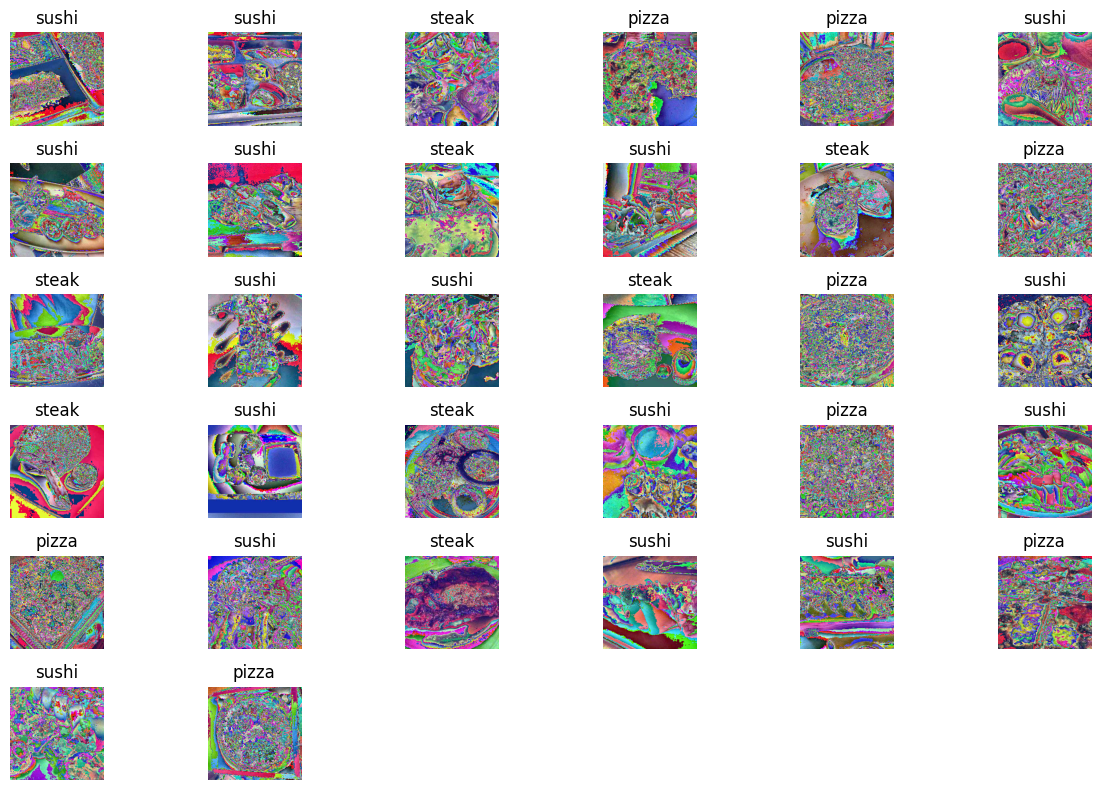

In [ ]:
#@title Quick peek at a batch
images, labels = next(iter(train_loader))
grid_cols = 6
grid_rows = max(1, len(images) // grid_cols + (len(images) % grid_cols > 0))

plt.figure(figsize=(12, 8))
for i in range(min(len(images), grid_cols*grid_rows)):
    plt.subplot(grid_rows, grid_cols, i+1)
    # De-normalize for display using weights meta
    img = images[i]
    # Convert back to PIL for visualization (approximate; colors may look a touch off)
    pil = to_pil_image(img)
    plt.imshow(pil)
    plt.title(class_names[labels[i].item()])
    plt.axis("off")
plt.tight_layout()
plt.show()


## 3. Model: pretrained backbone + custom classifier

We’ll create an EfficientNet‑B0 with pretrained weights and replace the final **linear** layer to output **3** classes.  
Two training phases:

1. **Feature extraction**: freeze the backbone (fast, strong baseline).
2. **Fine‑tuning**: unfreeze a few top blocks and train with a smaller LR for better accuracy.


In [ ]:
#@title Build model (feature extractor first)
from copy import deepcopy
from torch import optim

set_seed(42)

base_model = efficientnet_b0(weights=weights)
in_features = base_model.classifier[1].in_features

# Replace classifier head
base_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features, len(class_names))
)

# Freeze all feature layers (feature extraction phase)
for p in base_model.features.parameters():
    p.requires_grad = False

model = base_model.to(device)

def count_trainable(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print(model.__class__.__name__, "trainable params:", count_trainable(model))


EfficientNet trainable params: 3843


In [ ]:
#@title Training helpers (accuracy, train/eval loops)
def accuracy_from_logits(logits, targets):
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

def run_epoch(model, loader, optimizer, criterion, train=True):
    if train:
        model.train()
    else:
        model.eval()
    epoch_loss, epoch_acc, n = 0.0, 0.0, 0

    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)

        with torch.set_grad_enabled(train):
            logits = model(x)
            loss = criterion(logits, y)

        if train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

        bs = x.size(0)
        epoch_loss += loss.item() * bs
        epoch_acc  += accuracy_from_logits(logits, y) * bs
        n += bs

    return epoch_loss / n, epoch_acc / n

def train_model(model, train_loader, test_loader, epochs, lr):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=lr)
    criterion = nn.CrossEntropyLoss()

    best_state = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, epochs+1):
        tl, ta = run_epoch(model, train_loader, optimizer, criterion, train=True)
        vl, va = run_epoch(model, test_loader,  optimizer, criterion, train=False)

        history["train_loss"].append(tl); history["train_acc"].append(ta)
        history["val_loss"].append(vl);   history["val_acc"].append(va)

        if va > best_acc:
            best_acc = va
            best_state = deepcopy(model.state_dict())

        print(f"Epoch {epoch:02d} | "
              f"train_loss={tl:.4f} acc={ta:.4f} | "
              f"val_loss={vl:.4f} acc={va:.4f}")
    model.load_state_dict(best_state)
    return history

def plot_curves(history):
    epochs = range(1, len(history["train_loss"])+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="train")
    plt.plot(epochs, history["val_loss"], label="val")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Loss"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="train")
    plt.plot(epochs, history["val_acc"], label="val")
    plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Accuracy"); plt.legend()
    plt.show()


### Phase 1 — Feature extraction (freeze backbone)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 01 | train_loss=1.0348 acc=0.4889 | val_loss=0.8161 acc=0.8133


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 02 | train_loss=0.8170 acc=0.8000 | val_loss=0.7384 acc=0.8667


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 03 | train_loss=0.7148 acc=0.8711 | val_loss=0.7011 acc=0.7867


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 04 | train_loss=0.6320 acc=0.8489 | val_loss=0.6383 acc=0.7867


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 05 | train_loss=0.5222 acc=0.9156 | val_loss=0.5618 acc=0.8933


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 06 | train_loss=0.4886 acc=0.8844 | val_loss=0.5453 acc=0.8800


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 07 | train_loss=0.4593 acc=0.8933 | val_loss=0.4808 acc=0.8667


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 08 | train_loss=0.4457 acc=0.8933 | val_loss=0.4759 acc=0.8800


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 09 | train_loss=0.4206 acc=0.8889 | val_loss=0.4670 acc=0.8800


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10 | train_loss=0.3511 acc=0.9467 | val_loss=0.4735 acc=0.8400


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11 | train_loss=0.3655 acc=0.9156 | val_loss=0.4741 acc=0.8133


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12 | train_loss=0.3319 acc=0.9333 | val_loss=0.4089 acc=0.8933


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13 | train_loss=0.3207 acc=0.9200 | val_loss=0.3981 acc=0.8667


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14 | train_loss=0.2994 acc=0.9644 | val_loss=0.4062 acc=0.8800


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15 | train_loss=0.3087 acc=0.9422 | val_loss=0.4319 acc=0.8533


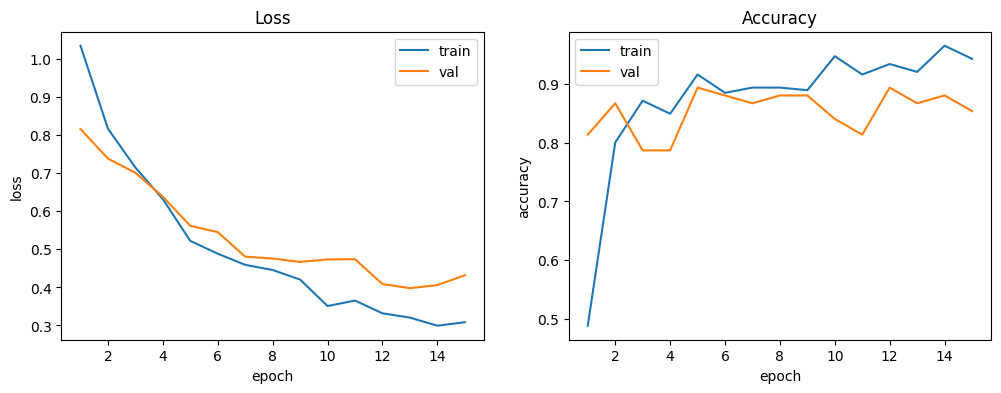

In [ ]:
#@title Train (feature extraction)
EPOCHS_FE = 15
LR_FE      = 1e-3

hist_fe = train_model(model, train_loader, test_loader, epochs=EPOCHS_FE, lr=LR_FE)
plot_curves(hist_fe)


### Phase 2 — Fine‑tuning top blocks

Now we’ll **unfreeze** the top portion of the backbone to slightly adjust pretrained weights to our data.

- Unfreeze last 2 blocks of EfficientNet (heuristic).
- Use a **smaller learning rate** for the backbone and a larger LR for the head.
- Train for a few more epochs.


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[FT] Epoch 01 | train_loss=0.4840 acc=0.9422 | val_loss=0.5056 acc=0.8933


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[FT] Epoch 02 | train_loss=0.4104 acc=0.9378 | val_loss=0.4705 acc=0.8800


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[FT] Epoch 03 | train_loss=0.3853 acc=0.9156 | val_loss=0.4484 acc=0.8400


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[FT] Epoch 04 | train_loss=0.3200 acc=0.9600 | val_loss=0.4046 acc=0.8800


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[FT] Epoch 05 | train_loss=0.3061 acc=0.9511 | val_loss=0.3629 acc=0.9067


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[FT] Epoch 06 | train_loss=0.2863 acc=0.9422 | val_loss=0.3367 acc=0.9067


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[FT] Epoch 07 | train_loss=0.2768 acc=0.9200 | val_loss=0.3134 acc=0.9200


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[FT] Epoch 08 | train_loss=0.2344 acc=0.9467 | val_loss=0.3038 acc=0.9067


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[FT] Epoch 09 | train_loss=0.2159 acc=0.9467 | val_loss=0.3187 acc=0.8667


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[FT] Epoch 10 | train_loss=0.2091 acc=0.9556 | val_loss=0.3017 acc=0.8933


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[FT] Epoch 11 | train_loss=0.1717 acc=0.9644 | val_loss=0.3124 acc=0.8933


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[FT] Epoch 12 | train_loss=0.1626 acc=0.9689 | val_loss=0.2847 acc=0.9067


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[FT] Epoch 13 | train_loss=0.1628 acc=0.9867 | val_loss=0.2972 acc=0.9200


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[FT] Epoch 14 | train_loss=0.1485 acc=0.9911 | val_loss=0.2667 acc=0.9067


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[FT] Epoch 15 | train_loss=0.1468 acc=0.9822 | val_loss=0.2866 acc=0.8933


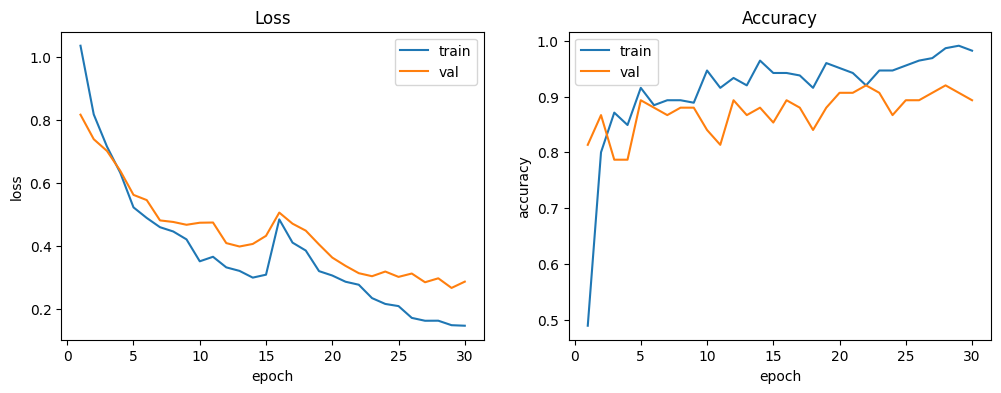

In [ ]:
#@title Unfreeze top blocks & use differential learning rates
# EfficientNet-B0 features: sequential blocks at indices 0..8
# We'll unfreeze the last two feature blocks for a gentle fine-tune.
unfrozen_idxs = [-1, -2]  # last two blocks
for idx in unfrozen_idxs:
    for p in model.features[idx].parameters():
        p.requires_grad = True

# Build parameter groups
head_params = [p for p in model.classifier.parameters() if p.requires_grad]
backbone_params = [p for p in model.features.parameters() if p.requires_grad]

optimizer = torch.optim.AdamW([
    {"params": backbone_params, "lr": 5e-5},
    {"params": head_params,     "lr": 5e-4},
])

criterion = nn.CrossEntropyLoss()

def train_finetune(model, train_loader, test_loader, optimizer, criterion, epochs=5):
    hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best = deepcopy(model.state_dict()); best_acc = 0.0

    for ep in range(1, epochs+1):
        tl, ta = run_epoch(model, train_loader, optimizer, criterion, train=True)
        vl, va = run_epoch(model, test_loader,  optimizer, criterion, train=False)
        hist["train_loss"].append(tl); hist["train_acc"].append(ta)
        hist["val_loss"].append(vl);   hist["val_acc"].append(va)
        if va > best_acc:
            best_acc = va; best = deepcopy(model.state_dict())
        print(f"[FT] Epoch {ep:02d} | "
              f"train_loss={tl:.4f} acc={ta:.4f} | val_loss={vl:.4f} acc={va:.4f}")
    model.load_state_dict(best)
    return hist

EPOCHS_FT = 15
hist_ft = train_finetune(model, train_loader, test_loader, optimizer, criterion, epochs=EPOCHS_FT)

# Merge histories for a single view (optional)
merged = {
    "train_loss": hist_fe["train_loss"] + hist_ft["train_loss"],
    "train_acc":  hist_fe["train_acc"]  + hist_ft["train_acc"],
    "val_loss":   hist_fe["val_loss"]   + hist_ft["val_loss"],
    "val_acc":    hist_fe["val_acc"]    + hist_ft["val_acc"],
}
plot_curves(merged)


## 4. Evaluation: confusion matrix & metrics

In [ ]:
#@title Evaluate on test set and collect predictions
import torch.nn.functional as F

model.eval()
all_probs = []
all_preds = []
all_targets = []

with torch.inference_mode():
    for x, y in tqdm(test_loader):
        x = x.to(device)
        logits = model(x)
        probs = F.softmax(logits, dim=1).cpu()
        preds = probs.argmax(dim=1)
        all_probs.append(probs)
        all_preds.append(preds)
        all_targets.append(y)

all_probs = torch.cat(all_probs)
all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

test_acc = (all_preds == all_targets).float().mean().item()
print(f"Test accuracy: {test_acc:.4f}")


  0%|          | 0/3 [00:00<?, ?it/s]

Test accuracy: 0.9200


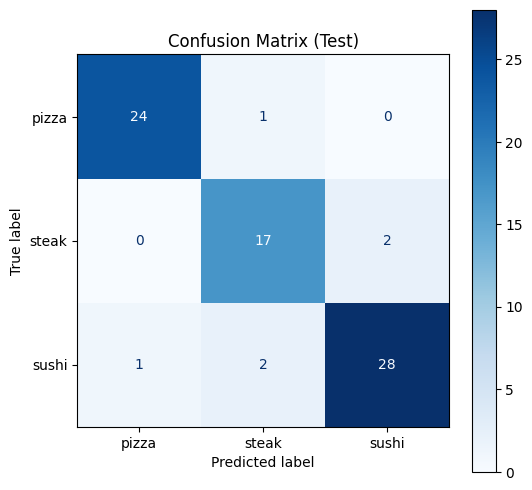


Classification Report:

              precision    recall  f1-score   support

       pizza       0.96      0.96      0.96        25
       steak       0.85      0.89      0.87        19
       sushi       0.93      0.90      0.92        31

    accuracy                           0.92        75
   macro avg       0.91      0.92      0.92        75
weighted avg       0.92      0.92      0.92        75



In [ ]:
#@title Confusion matrix
!pip -q install scikit-learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(all_targets.numpy(), all_preds.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, values_format="d", cmap="Blues")
plt.title("Confusion Matrix (Test)")
plt.show()

print("\nClassification Report:\n")
print(classification_report(all_targets.numpy(), all_preds.numpy(), target_names=class_names))


### The "most wrong" predictions

Let’s find misclassifications where the model was **very confident but wrong** (highest wrong probability).

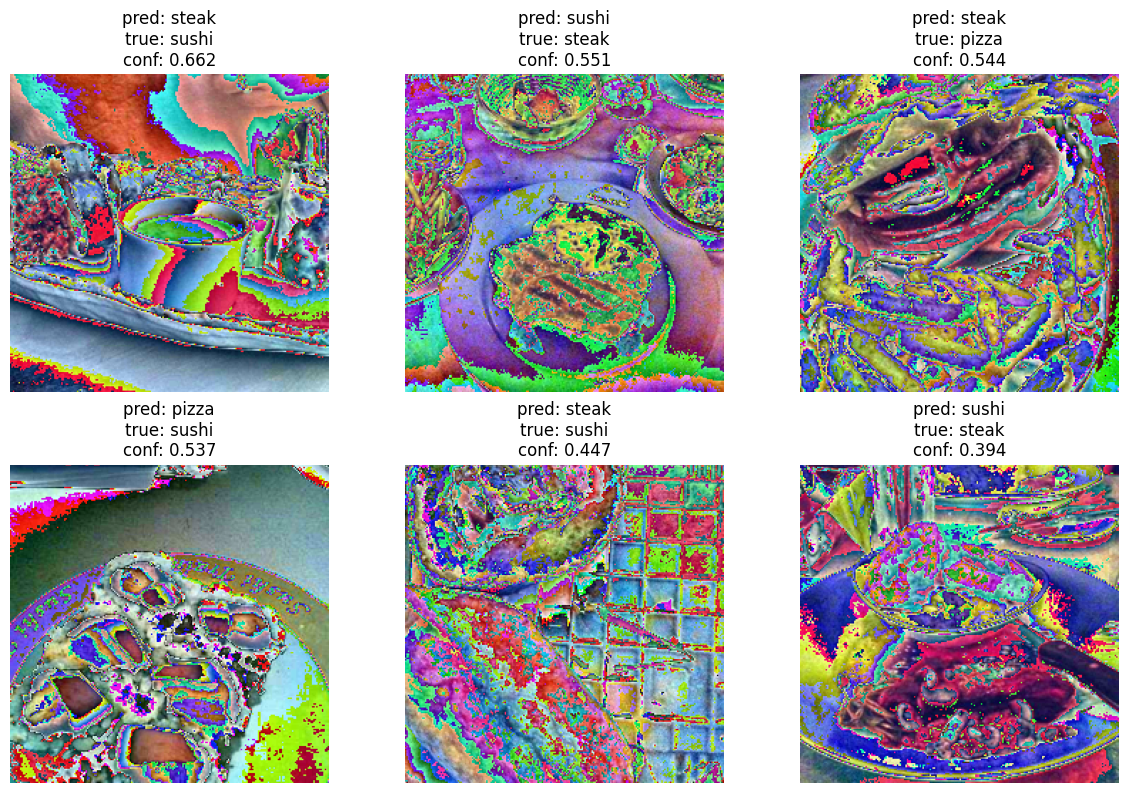

In [ ]:
#@title Show top-6 most confident wrong predictions
wrong_idxs = (all_preds != all_targets).nonzero(as_tuple=False).squeeze().tolist()
if isinstance(wrong_idxs, int): wrong_idxs = [wrong_idxs]

if len(wrong_idxs) == 0:
    print("No misclassifications to display! 🎉")
else:
    # Build a flat list of test dataset indices in loader order
    # DataLoader keeps original order when shuffle=False (we did that for test_loader)
    test_indices = list(range(len(test_data)))
    # Map loader batch order to dataset indices:
    # Since shuffle=False, the order is identical.
    # We'll just use test_indices directly.
    conf_scores = all_probs[range(len(all_probs)), all_preds].numpy()
    wrong_conf = [(i, conf_scores[i]) for i in wrong_idxs]
    wrong_conf.sort(key=lambda x: x[1], reverse=True)  # highest wrong confidence first

    k = min(6, len(wrong_conf))
    plt.figure(figsize=(12, 8))
    for j in range(k):
        idx, conf = wrong_conf[j]
        img_path, true_label = test_data.samples[idx]
        img, _ = test_data[idx]  # already transformed
        plt.subplot(2, 3, j+1)
        plt.imshow(to_pil_image(img))
        plt.title(f"pred: {class_names[all_preds[idx]]}\ntrue: {class_names[all_targets[idx]]}\nconf: {conf:.3f}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


## 5. Inference on a custom image (URL or upload)

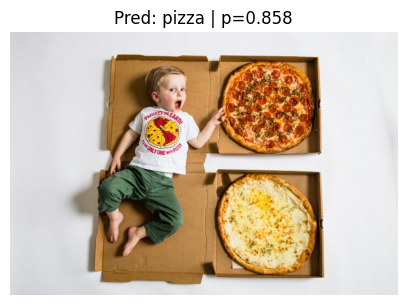

In [ ]:
#@title Predict on a custom image URL
import io, requests
from PIL import Image

def predict_image(pil_img, transform, model, class_names):
    model.eval()
    with torch.inference_mode():
        x = transform(pil_img).unsqueeze(0).to(device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().squeeze()
        pred_idx = int(torch.argmax(probs))
    return pred_idx, probs

# You can change this URL to a pizza/steak/sushi photo
image_url = "https://tinybeans.com/wp-content/uploads/2020/02/pizza-feb-2020-3.jpg?resize=768,521" #@param {type:"string"}

try:
    img = Image.open(io.BytesIO(requests.get(image_url, timeout=15).content)).convert("RGB")
    pred_idx, probs = predict_image(img, auto_transforms, model, class_names)
    plt.figure(figsize=(5,5)); plt.imshow(img); plt.axis("off")
    plt.title(f"Pred: {class_names[pred_idx]} | p={probs[pred_idx]:.3f}")
    plt.show()
except Exception as e:
    print("Failed to load image:", e)


## 6. Exercises


1. **Train longer**: Increase epochs in both phases and observe learning curves and accuracy gains.
2. **Try another backbone**: Replace `efficientnet_b0` with `resnet18`, `convnext_tiny`, or `vit_b_16`. Update the weights enum and head size accordingly.
3. **Data augmentation**: Instead of `weights.transforms()`, build a manual transform that includes `RandomResizedCrop`, `ColorJitter`, or `RandomHorizontalFlip`. Ensure you still normalize with ImageNet stats.
4. **Confusion insights**: Inspect which pairs of classes are most confused. Add per‑class accuracy and a few sample images for each class.
5. **Progressive unfreezing**: Start with only the classifier, then unfreeze gradually more blocks (last 1, last 2, last 3...). Track the effect on validation accuracy.
6. **Differential LRs**: Experiment with learning rates across parameter groups. What happens if the backbone LR is too high?
7. **Save & load**: Save the best model `state_dict` to disk and create a function that reloads it to run inference elsewhere.
8. **Generalization test**: Try images outside the three classes (e.g., salad). How does the model behave? Discuss out‑of‑distribution considerations.


---

### Key takeaways
- Use **weights‑provided transforms** to match the backbone’s training distribution.
- Start with **feature extraction** for quick wins; then **fine‑tune** selectively for extra performance.
- Visual diagnostics (curves, confusion matrix, "most wrong") help you prioritize improvements.
